In [188]:
# Task:
# postprocessing analysis
# use Joback method (using functional groups to calc. gap) 
# find the rep. with qm9 and save the final file in a .csv file
# Joback has 6% error on qm9 values
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from numpy import ndarray
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc, rcParams

import seaborn as sns

#! pip install rdkit-pypi
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')
from rdkit import Chem
print ("!!!!!!!!!!!!!!!!!!!!!we are after importing rdkit!!!!!!!!!!!!!!!!!!")
#! pip install thermo
#from thermo import Joback
# loading SMILES data using Chainer Chemistry
#! pip install chainer_chemistry
from chainer_chemistry.datasets.molnet import get_molnet_dataset
from chainer_chemistry.datasets.numpy_tuple_dataset import NumpyTupleDataset
from chainer_chemistry.dataset.preprocessors import GGNNPreprocessor
from scipy import stats

!!!!!!!!!!!!!!!!!!!!!we are after importing rdkit!!!!!!!!!!!!!!!!!!


Text(0.5, 0, '!!!Ariaaaal')

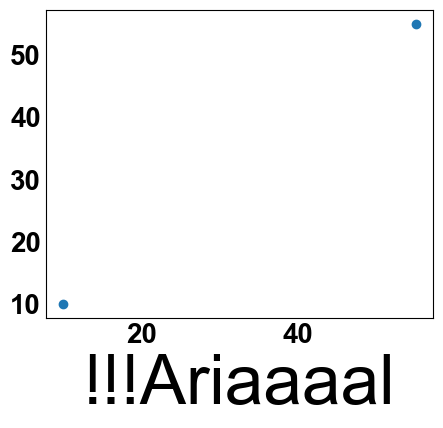

In [189]:
# check the font !!!!!!!!!!!!!!!!!!!!!
# switch to Arial
# if not working: delet ~/.catch/matplotlib
plt.rcParams["font.family"] = "Arial"
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.fonttype'] = 42
mpl.font_manager.FontManager()

rc('font', weight='bold')
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter([10, 55], [10, 55])
ax.tick_params(axis='both', length=0, width=1.5, colors='black', grid_alpha=0, labelsize=20)
plt.xlabel('!!!Ariaaaal', fontname='Arial', fontsize=50)

In [2]:
# load the generated SMILES from the RCGAN Model
csv_name = './../experiments/regular/keep/Initial_training.csv'
gen_SMILES = pd.read_csv(csv_name)

gen_SMILES_initial = gen_SMILES
initial_num_samples = gen_SMILES.shape[0]
print ('Number of gen SMILES', gen_SMILES.shape[0])
sanitized_idx = []
# make sure about Canonical SMILES
for i, s in enumerate (gen_SMILES['SMILES'].values):
    try:
         m = Chem.MolFromSmiles(s, sanitize=True)
         ss = Chem.MolToSmiles(m,)
         gen_SMILES['SMILES'].values[i] = ss
         sanitized_idx.append(i)
    except:
         print (s, 'is not sanitized')
gen_SMILES = gen_SMILES.iloc[sanitized_idx]
gen_SMILES.reset_index(drop = True, inplace = True)

print ('Number of gen SMILES after getting Canonical', gen_SMILES.shape[0])

Number of gen SMILES 1315
Number of gen SMILES after getting Canonical 1315


In [5]:
# look for any repetitive samples
print (sum(gen_SMILES.duplicated(subset=['SMILES'])))
gen_SMILES = gen_SMILES.drop_duplicates(subset=['SMILES'], keep='first')

0


In [6]:
sum(gen_SMILES.duplicated(subset=['SMILES']))
print (gen_SMILES.shape)

(1315, 4)


In [7]:
#val_accurate.to_csv('gen_new_noscreen_all_joback.csv', index = False)
preprocessor = GGNNPreprocessor()

with open('./../data/trainingsets/60000_train_regular_pubqc/image_train.pickle', 'rb') as f:
    X_smiles_train0, SMILES_train0, y_train00 = pickle.load(f)
    
with open('./../data/trainingsets/60000_train_regular_pubqc/image_test.pickle', 'rb') as f:
    X_smiles_val0, SMILES_val0, y_val00 = pickle.load(f)

with open('./../data/trainingsets/60000_train_regular_pubqc/tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)
tokenizer[0] = ' '

In [8]:
SMILES_ = np.concatenate ((SMILES_train0, SMILES_val0))
print ('First SMILES in pubqc', SMILES_[0])
SMILES = []

# save as canonical SMILES to find duplicates
# the gen smiles already converted to Canonical
for s in SMILES_:
    try:
        m = Chem.MolFromSmiles (s[:-1])
        ss = Chem.MolToSmiles(m)
        SMILES.append(ss)
    except Exception as error:
        print (error)
#SMILES = SMILES.astype('str')
print ('First SMILES in pubqc', SMILES[0])
print (np.array(SMILES).shape)
print (SMILES_.shape)
SMILES_pubqc = np.array(SMILES)
gap_pubqc = np.concatenate((y_train00, y_val00))
X_SMILES_pubqc = np.concatenate((X_smiles_train0, X_smiles_val0))

data_pubqc = {}
data_pubqc ['SMILES'] = SMILES_pubqc
data_pubqc ['gap'] = gap_pubqc
data_pubqc = pd.DataFrame(data_pubqc)

First SMILES in pubqc Nc1nc[nH]c2ncnc1-2.
First SMILES in pubqc Nc1nc[nH]c2ncnc1-2
(130920,)
(130920,)


In [10]:
SMILES_val = []
for s in SMILES_val0:
    try:
        m = Chem.MolFromSmiles (s[:-1])
        ss = Chem.MolToSmiles(m)
        SMILES_val.append(ss)
    except Exception as error:
        print (error)

SMILES_train = []
for s in SMILES_train0:
    try:
        m = Chem.MolFromSmiles (s[:-1])
        ss = Chem.MolToSmiles(m)
        SMILES_train.append(ss)
    except Exception as error:
        print (error)

data_pubqc_train = {}
data_pubqc_train ['SMILES'] = SMILES_train
data_pubqc_train ['gap'] = y_train00
data_pubqc_train = pd.DataFrame(data_pubqc_train)

data_pubqc_test = {}
data_pubqc_test ['SMILES'] = SMILES_val
data_pubqc_test ['gap'] = y_val00
data_pubqc_test = pd.DataFrame(data_pubqc_test)

In [12]:
# find the repetitives from train
database_samples_train = pd.merge(gen_SMILES, data_pubqc_train, on = 'SMILES', how = 'inner')
print ( "Same generated SMILES compared to train: \n{}".format(database_samples_train))

Same generated SMILES compared to train: 
                    SMILES  des_gap   pred_gap  Err_pred_des     gap
0           C=C1C(C)CCCC1C   8.2988   7.495655      0.096778   7.244
1     CCCCCCCOC(=O)C(C)CCC   6.8302   7.702643      0.127733   7.529
2        CCCC(CC)CC(C)(C)O   9.7336   8.649860      0.111340   8.795
3        CC(C)CCCCCCCCCCCO   9.8362   8.737241      0.111726   9.018
4             CCC(C)(C)CCO   8.7509   8.991986      0.027550   8.890
5     CCCCCCCCCCC(O)(O)CCC   4.7396   9.011425      0.901305   9.138
6       CC1CCC(C)(C)C(C)C1  10.3670   9.500378      0.083594   9.647
7     CCCCCC(CC(C)C)C(C)CC  10.1204   9.632627      0.048197   9.834
8     CCCC(C)CC(CC)CCC(C)C   6.9355   9.681170      0.395886   9.641
9   CCC(C)CC(C)CC(C)CC(C)C   8.6864   9.752189      0.122696   9.747
10           CCCCC(CCC)CCC  10.4087   9.768443      0.061512   9.957
11    CCCCC(C)C(CC)CCC(C)C   9.9229   9.806534      0.011727   9.979
12             CCCCCCCCCCC   9.8362   9.818226      0.001827 

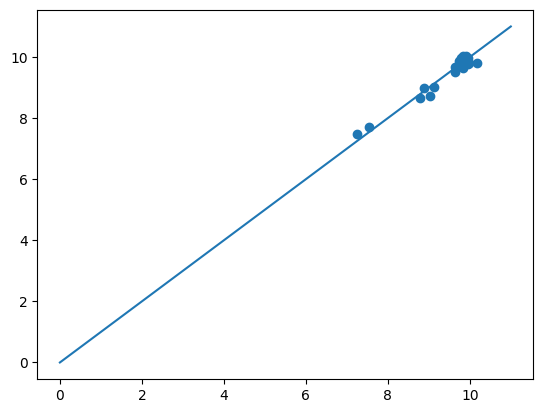

In [13]:
plt.scatter (database_samples_train['gap'], database_samples_train['pred_gap'])
plt.plot ([0, 11], [0, 11])

In [21]:
for rep_smile in database_samples_train['SMILES']:
    indices = np.where ( [SMILES_pubqc==rep_smile])
    print (data_pubqc.iloc[indices[1]])

               SMILES    gap
43935  C=C1C(C)CCCC1C  7.244
                     SMILES    gap
29979  CCCCCCCOC(=O)C(C)CCC  7.529
                  SMILES    gap
28169  CCCC(CC)CC(C)(C)O  8.795
                  SMILES    gap
68709  CC(C)CCCCCCCCCCCO  9.018
             SMILES   gap
14265  CCC(C)(C)CCO  8.89
                     SMILES    gap
68066  CCCCCCCCCCC(O)(O)CCC  9.138
                   SMILES    gap
69675  CC1CCC(C)(C)C(C)C1  9.647
                     SMILES    gap
43519  CCCCCC(CC(C)C)C(C)CC  9.834
                     SMILES    gap
70064  CCCC(C)CC(CC)CCC(C)C  9.641
                       SMILES    gap
48462  CCC(C)CC(C)CC(C)CC(C)C  9.747
              SMILES    gap
92195  CCCCC(CCC)CCC  9.957
                     SMILES    gap
92403  CCCCC(C)C(CC)CCC(C)C  9.979
            SMILES     gap
27750  CCCCCCCCCCC  10.185
                   SMILES    gap
92315  CCCCC(C)CC(C)(C)CC  9.946
                     SMILES    gap
48451  CCCCC(C)CCC(C)(C)CCC  9.747
                    SMILES

In [22]:
# find the repetitives from test
database_samples_test = pd.merge(gen_SMILES, data_pubqc_test, on = 'SMILES', how = 'inner')
print ( "Same generated SMILES compared to train: \n{}".format(database_samples_test))

Same generated SMILES compared to train: 
                 SMILES  des_gap  pred_gap  Err_pred_des    gap
0     CCCCCCCCOC1CCCCC1   9.7726  9.217565      0.056795  8.612
1    CC1CCCC1(C)C1CCCC1   6.4257  9.574300      0.490001  9.783
2  CCCC(C)C(CC)(CCC)CCC   8.4415  9.610742      0.138511  9.709
3   CCCCCCCCC(C)C(C)CCC  10.5606  9.814297      0.070669  9.940
4    CCCCC(CC)C(C)C(C)C  10.3445  9.854548      0.047363  9.744


In [23]:
for rep_smile in database_samples_test['SMILES']:
    indices = np.where ( [SMILES_pubqc==rep_smile])
    print (data_pubqc.iloc[indices[1]])

                   SMILES    gap
112218  CCCCCCCCOC1CCCCC1  8.612
                    SMILES    gap
108318  CC1CCCC1(C)C1CCCC1  9.783
                      SMILES    gap
121264  CCCC(C)C(CC)(CCC)CCC  9.709
                     SMILES   gap
126218  CCCCCCCCC(C)C(C)CCC  9.94
                    SMILES    gap
106388  CCCCC(CC)C(C)C(C)C  9.744


In [24]:
# find the repetitives from whole library
rep_samples = pd.merge(gen_SMILES, data_pubqc, on = 'SMILES', how = 'inner')
rep_samples
#print ( "Same generated SMILES compared to train: \n{}".format(database_samples))

,SMILES,des_gap,pred_gap,Err_pred_des,gap
0,C=C1C(C)CCCC1C,8.2988,7.495655,0.096778,7.244
1,CCCCCCCOC(=O)C(C)CCC,6.8302,7.702643,0.127733,7.529
2,CCCC(CC)CC(C)(C)O,9.7336,8.649860,0.111340,8.795
3,CC(C)CCCCCCCCCCCO,9.8362,8.737241,0.111726,9.018
4,CCC(C)(C)CCO,8.7509,8.991986,0.027550,8.890
5,CCCCCCCCCCC(O)(O)CCC,4.7396,9.011425,0.901305,9.138
6,CCCCCCCCOC1CCCCC1,9.7726,9.217565,0.056795,8.612
7,CC1CCC(C)(C)C(C)C1,10.3670,9.500378,0.083594,9.647
8,CC1CCCC1(C)C1CCCC1,6.4257,9.574300,0.490001,9.783
9,CCCC(C)C(CC)(CCC)CCC,8.4415,9.610742,0.138511,9.709


In [25]:
#r2_score(rep_samples['gap'], rep_samples['pred_gap'])

In [26]:
from tensorflow.keras.models import Model, load_model

with open('./../data/trainingsets/60000_train_regular_pubqc/image_train.pickle', 'rb') as f:
    X_smiles_train, SMILES_train, y_train0 = pickle.load(f)

with open('./../data/trainingsets/60000_train_regular_pubqc/image_test.pickle', 'rb') as f:
    X_smiles_test, SMILES_test, y_test0 = pickle.load(f)
    
with open('./../data/trainingsets/60000_train_regular_pubqc/tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)
tokenizer[0] = ' '

encoder = load_model('./../data/nns/keep/encoder.h5')
decoder = load_model('./../data/nns/keep/decoder.h5')
model = load_model('./../data/nns/keep/ae_model.h5')
train_atoms_embedding, train_bonds_embedding, _ = encoder.predict([X_smiles_train], verbose=0)
atoms_embedding, bonds_embedding, _ = encoder.predict([X_smiles_train], verbose=0)
atoms_val, bonds_val, _ = encoder.predict([X_smiles_test], verbose=0)



In [27]:
regressor =     load_model('./../data/nns/keep/regressor.h5')
regressor_top = load_model('./../data/nns/keep/regressor_top.h5')

In [28]:
pred_train = regressor.predict([atoms_embedding, bonds_embedding])
gap_max, gap_min = 11, 0
pred_train0 = pred_train*(gap_max-gap_min)+gap_min

  80/3316 [..............................] - ETA: 6s

2023-05-13 13:21:16.232501: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3316/3316 [==============================] - 7s 2ms/step


In [29]:
pred = regressor.predict([atoms_val, bonds_val])
gap_max, gap_min = 11, 0
pred0 = pred*(gap_max-gap_min)+gap_min

776/776 [==============================] - 2s 2ms/step


In [30]:
test_temp = pd.DataFrame({})
test_temp ['true_gap'] = y_test0
test_temp ['pred_gap'] = pred0
test_temp ['SMILES'] = SMILES_test

In [31]:
train_temp = pd.DataFrame({})
train_temp ['true_gap'] = y_train0
train_temp ['pred_gap'] = pred_train0
train_temp ['SMILES'] = SMILES_train

In [32]:
rep_samples

,SMILES,des_gap,pred_gap,Err_pred_des,gap
0,C=C1C(C)CCCC1C,8.2988,7.495655,0.096778,7.244
1,CCCCCCCOC(=O)C(C)CCC,6.8302,7.702643,0.127733,7.529
2,CCCC(CC)CC(C)(C)O,9.7336,8.649860,0.111340,8.795
3,CC(C)CCCCCCCCCCCO,9.8362,8.737241,0.111726,9.018
4,CCC(C)(C)CCO,8.7509,8.991986,0.027550,8.890
5,CCCCCCCCCCC(O)(O)CCC,4.7396,9.011425,0.901305,9.138
6,CCCCCCCCOC1CCCCC1,9.7726,9.217565,0.056795,8.612
7,CC1CCC(C)(C)C(C)C1,10.3670,9.500378,0.083594,9.647
8,CC1CCCC1(C)C1CCCC1,6.4257,9.574300,0.490001,9.783
9,CCCC(C)C(CC)(CCC)CCC,8.4415,9.610742,0.138511,9.709


In [33]:
test_temp ['SMILES_nodot'] = [i[:-1] for i in test_temp ['SMILES']]
train_temp ['SMILES_nodot'] = [i[:-1] for i in train_temp ['SMILES']]

In [34]:
pred_gap_rep = []
true_gap_rep = []
for i in rep_samples['SMILES']:
    test = test_temp.loc[test_temp ['SMILES_nodot']==i]
    train = train_temp.loc[train_temp ['SMILES_nodot']==i]
    if test.shape[0] != 0:
        pred_gap_rep.append(test['pred_gap'].iloc[0])
        true_gap_rep.append(test['true_gap'].iloc[0])
    if train.shape[0] != 0:
        print (train)
        pred_gap_rep.append(train['pred_gap'].iloc[0])
        true_gap_rep.append(train['true_gap'].iloc[0])
        

       true_gap  pred_gap           SMILES    SMILES_nodot
43935     7.244  7.495372  C=C1C(C)CCCC1C.  C=C1C(C)CCCC1C
       true_gap  pred_gap                 SMILES          SMILES_nodot
29979     7.529  7.702605  CCCCCCCOC(=O)C(C)CCC.  CCCCCCCOC(=O)C(C)CCC
       true_gap  pred_gap              SMILES       SMILES_nodot
28169     8.795  8.649422  CCCC(CC)CC(C)(C)O.  CCCC(CC)CC(C)(C)O
       true_gap  pred_gap              SMILES       SMILES_nodot
68709     9.018  8.737132  CC(C)CCCCCCCCCCCO.  CC(C)CCCCCCCCCCCO
       true_gap  pred_gap         SMILES  SMILES_nodot
14265      8.89  8.991926  CCC(C)(C)CCO.  CCC(C)(C)CCO
       true_gap  pred_gap                 SMILES          SMILES_nodot
68066     9.138  9.011566  CCCCCCCCCCC(O)(O)CCC.  CCCCCCCCCCC(O)(O)CCC
       true_gap  pred_gap               SMILES        SMILES_nodot
69675     9.647  9.500137  CC1CCC(C)(C)C(C)C1.  CC1CCC(C)(C)C(C)C1
       true_gap  pred_gap                 SMILES          SMILES_nodot
43519     9.834  9.6326

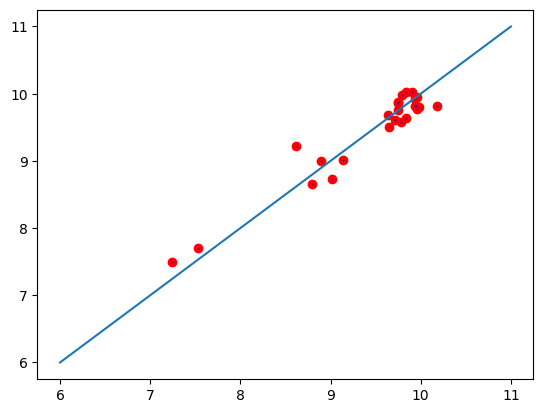

In [35]:
plt.scatter (rep_samples['gap'], pred_gap_rep, color='red')
plt.scatter (rep_samples['gap'], rep_samples['pred_gap'], color='blue', s=0.1)
plt.plot([6, 11], [6, 11])
#plt.scatter (rep_samples['gap'], pred_gap_rep, color='blue')

In [36]:
rep_samples

,SMILES,des_gap,pred_gap,Err_pred_des,gap
0,C=C1C(C)CCCC1C,8.2988,7.495655,0.096778,7.244
1,CCCCCCCOC(=O)C(C)CCC,6.8302,7.702643,0.127733,7.529
2,CCCC(CC)CC(C)(C)O,9.7336,8.649860,0.111340,8.795
3,CC(C)CCCCCCCCCCCO,9.8362,8.737241,0.111726,9.018
4,CCC(C)(C)CCO,8.7509,8.991986,0.027550,8.890
5,CCCCCCCCCCC(O)(O)CCC,4.7396,9.011425,0.901305,9.138
6,CCCCCCCCOC1CCCCC1,9.7726,9.217565,0.056795,8.612
7,CC1CCC(C)(C)C(C)C1,10.3670,9.500378,0.083594,9.647
8,CC1CCCC1(C)C1CCCC1,6.4257,9.574300,0.490001,9.783
9,CCCC(C)C(CC)(CCC)CCC,8.4415,9.610742,0.138511,9.709


In [37]:
# find the repetitives
database_samples = pd.merge(gen_SMILES, data_pubqc, on = 'SMILES', how = 'inner')

In [38]:
r2_score (database_samples['gap'], database_samples['pred_gap'])

0.9221901977785142

In [39]:
# get the relative error of Desired gap vs gap from qm9 for generated SMILES that are repetitive and are in qm9
mean_rel_diff_desired_gapqm9 = np.mean(np.abs((database_samples['des_gap'].values -
                                              database_samples['gap'].values) / 
                                              database_samples['gap'].values))
print ("mean of rel diff BW Desired (sampled in design model) and gap from qm9: {}".
                                                 format(mean_rel_diff_desired_gapqm9))


mean_rel_diff_desired_gapqm9 = np.mean(np.abs((database_samples['pred_gap'].values
                       - database_samples['gap'].values) / database_samples['gap'].values))
print ("mean of rel diff BW Predicted (from regresor) and gap from qm9: {}".
                                                 format(mean_rel_diff_desired_gapqm9))



mean of rel diff BW Desired (sampled in design model) and gap from qm9: 0.10217433125127261
mean of rel diff BW Predicted (from regresor) and gap from qm9: 0.01792178206672802


In [40]:
rep_smiles = rep_samples['SMILES']
for i in range(gen_SMILES.shape[0]):
    if (gen_SMILES['SMILES'][i] in list(rep_smiles)):
        print (i)
        gen_SMILES = gen_SMILES.drop(i)

gen_SMILES.reset_index(drop=True, inplace=True)
csv_name = csv_name.replace('.csv', '')
gen_SMILES.to_csv('{}_qm9removed.csv'.format(csv_name), index = False)

526
585
935
962
1087
1096
1165
1207
1218
1226
1232
1237
1248
1251
1259
1262
1263
1264
1272
1275
1278
1282
1286
1289
1290


less than 10 %  513 from total  1290 0.39767441860465114 %
less than 20 larger than 10%  434 from total  1290 0.3364341085271318 %
larger than 20 %  343 from total  1290 0.26589147286821707 %
total:  1290


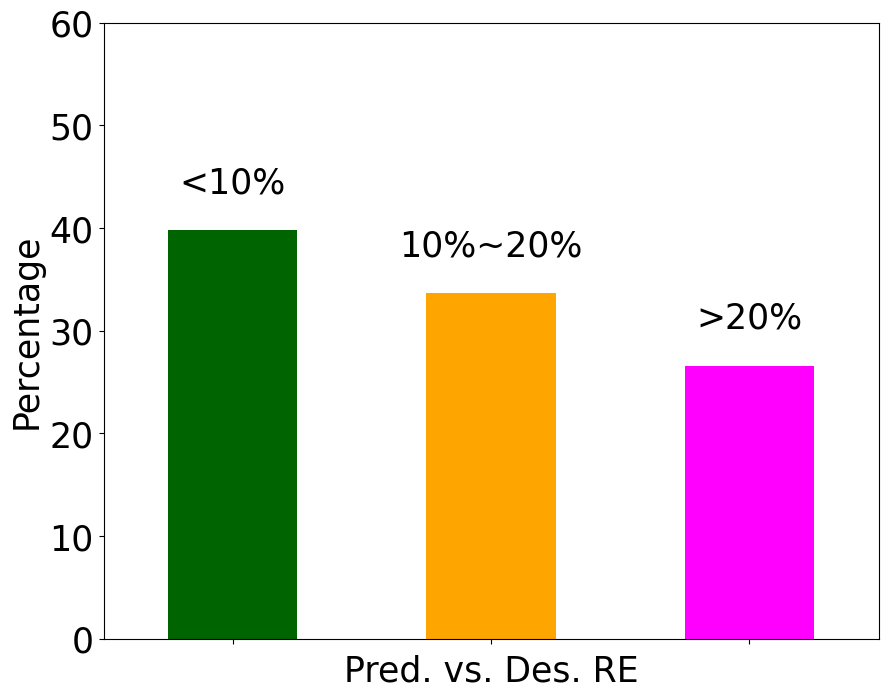

In [41]:

# plot the error bars <10%, <20%
re_less_10 = np.sum(gen_SMILES['Err_pred_des'].values <= 0.1)
print (
    'less than 10 % ', re_less_10, 
    'from total ', gen_SMILES.shape[0], 
    re_less_10/gen_SMILES.shape[0], "%")
re_less_20_big_10 = np.sum( (gen_SMILES['Err_pred_des'].values > 0.1) &  (gen_SMILES['Err_pred_des'].values <= 0.2) )
print ('less than 20 larger than 10% ', re_less_20_big_10, 'from total ', gen_SMILES.shape[0], re_less_20_big_10/gen_SMILES.shape[0], "%")
re_big_20 = np.sum(gen_SMILES['Err_pred_des'].values > 0.2)
print ('larger than 20 % ', re_big_20, 'from total ', gen_SMILES.shape[0], re_big_20/gen_SMILES.shape[0], "%")
print ('total: ', re_less_10 + re_less_20_big_10 + re_big_20)

plt.figure(figsize = (10, 8))
frequencies = [re_less_10/len(gen_SMILES)*100, re_less_20_big_10/len(gen_SMILES)*100, re_big_20/len(gen_SMILES)*100]
freq_series = pd.Series(frequencies)
ax = freq_series.plot(kind='bar', color = ['darkgreen', 'orange', 'magenta'])
rects = ax.patches
x_labels = [ ]
labels = ['<10%', '10%~20%', '>20%']

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 3, label,fontsize = 25,
            ha='center', va='bottom')
ax.set_xticklabels(x_labels)
plt.ylim(0,60)
plt.yticks(fontsize = 25)
plt.ylabel("Percentage", fontsize=25)
plt.xlabel("Pred. vs. Des. RE", fontsize=25)
plt.savefig('Err_pred_des_dist_3part.png', dpi=300)

In [42]:
gen_SMILES

,SMILES,des_gap,pred_gap,Err_pred_des
0,O=C1C=CC=CC=CC2=CC=CC2=S2C=CC=CC2=C1,1.3181,1.920509,0.457028
1,O=C1C=[SH]C1=C=[SH]C[SH]1CS1,1.8236,2.322022,0.273317
2,O=C1C=C2C=CC=CC=C3N=C3SC=CC=C=C2N1,3.3567,2.332190,0.305213
3,C=C=C1C=CC=C(CSCC)N=NC=NC=C1,3.4055,2.579761,0.242472
4,O=CC1=CC=CC=Cc2ncccc2SN1,1.5051,2.615154,0.737528
...,...,...,...,...
1285,C1=CC=NC(Nc2ccccc2)=CC=C1,3.6871,3.160462,0.142833
1286,CCCC1=CC=C(CS)SC=C1,3.0730,3.502519,0.139772
1287,CC(CN=NOO)CC1C=CC=CNOCCNCN(C)O1,3.6843,4.282492,0.162363
1288,CC(=O)OC1=C(O)C(=O)N=CC=NC=C1,3.9803,2.987678,0.249384


1290 unique samples from total of 1315
r2 0.47945941251368607
MAE_pred_des 1.1731611176744186
Fractioned MAE_pred_des 0.16103252715583255
RMSE_pred_des 1.4751564335473653
Fractioned_RMSE_pred_des 0.2168557425990149


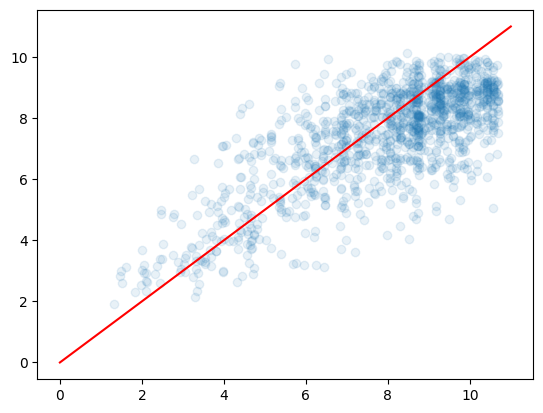

In [43]:
des_gap = np.array (gen_SMILES['des_gap'])
pred_gap = np.array (gen_SMILES['pred_gap'])
#pred_gap = np.random.normal (31, 4, des_gap.shape[0])
print ("{} unique samples from total of {}".format(des_gap.shape[0], initial_num_samples))

np.random.seed(10)
plt.scatter (des_gap, pred_gap, alpha=0.1)
plt.plot([0, 11], [0, 11], color='red')

print ('r2', r2_score(des_gap, pred_gap))

N = des_gap.shape[0]
MAE_pred_des = mean_absolute_error(pred_gap, des_gap)
print ("MAE_pred_des", MAE_pred_des)
# Fractioned MAE, more normalized
Fractioned_MAE_pred_des = 0
for pred, des in zip(pred_gap, des_gap):
    Fractioned_MAE_pred_des = Fractioned_MAE_pred_des +  abs(des-pred)/des
Fractioned_MAE_pred_des = Fractioned_MAE_pred_des/N
print ("Fractioned MAE_pred_des", Fractioned_MAE_pred_des)

# root mean squared error (RMSE), sqrt(sklearn ouputs MSE)
RMSE_pred_des = mean_squared_error(pred_gap, des_gap)**0.5
print ("RMSE_pred_des", RMSE_pred_des)

Fractioned_RMSE_pred_des = 0
for pred, des in zip(pred_gap, des_gap):
    Fractioned_RMSE_pred_des = Fractioned_RMSE_pred_des + ((des-pred)/des)**2
Fractioned_RMSE_pred_des = (Fractioned_RMSE_pred_des/N)**0.5
print ("Fractioned_RMSE_pred_des", Fractioned_RMSE_pred_des)

In [44]:
des_gap.shape[0]

1290

In [49]:
max_less20 = 0.79
good_rand = []
for rand in range( 10000, 20000):
    np.random.seed(rand)
    idx = np.random.choice (range(0, des_gap.shape[0]), 510, replace=False)
    gen_SMILES_sampled = gen_SMILES.iloc[idx]
    re_less_20 = np.sum(gen_SMILES_sampled['Err_pred_des'].values <= 0.2)
    re_less_20_per = re_less_20/gen_SMILES_sampled.shape[0]
    if re_less_20_per>max_less20:
        good_rand.append(rand)
        print(rand)
        print (re_less_20_per)
good_rand

14850
0.7941176470588235
17313
0.792156862745098
17865
0.7980392156862746
18715
0.7901960784313725
19422
0.796078431372549


[14850, 17313, 17865, 18715, 19422]

In [73]:
# sampling the generated ones
# 17865
np.random.seed(17865)
idx = np.random.choice (range(0, des_gap.shape[0]), 510, replace=False)
gen_SMILES_sampled = gen_SMILES.iloc[idx]
print (gen_SMILES_sampled.shape)

(510, 4)


In [74]:
# add any samples with pred_gap < 2.2 (eV) from the original generated samples
gen_SMILES_sampled = gen_SMILES_sampled.append(gen_SMILES.loc[gen_SMILES['pred_gap']<2.2])

print (sum(gen_SMILES_sampled.duplicated(subset=['SMILES'])))
gen_SMILES_sampled = gen_SMILES_sampled.drop_duplicates(subset=['SMILES'], keep='first')

print (gen_SMILES_sampled.shape)

2
(510, 4)


r2 0.5278960416225937
larger than 20 %  407 from total  510 0.7980392156862746 %
MAE_pred_des 1.0709036225490196
Fractioned MAE_pred_des 0.14183194174225927
RMSE_pred_des 1.3457732680929813
Fractioned_RMSE_pred_des 0.19074586046718317
pearsonr: 0.7807


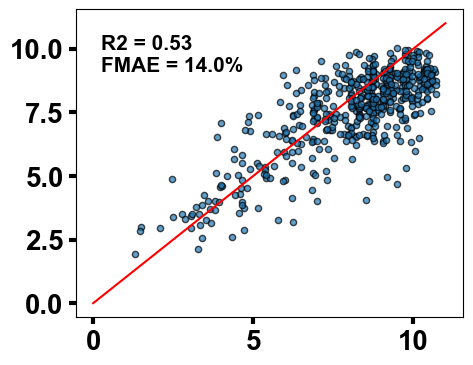

In [194]:
print ('r2', r2_score(gen_SMILES_sampled ['des_gap'], gen_SMILES_sampled['pred_gap']))
r2 = r2_score(gen_SMILES_sampled ['des_gap'], gen_SMILES_sampled['pred_gap'])
re_less_20 = np.sum(gen_SMILES_sampled['Err_pred_des'].values <= 0.2)
print ('larger than 20 % ', re_less_20, 'from total ', gen_SMILES_sampled.shape[0], re_less_20/gen_SMILES_sampled.shape[0], "%")

N = gen_SMILES_sampled.shape[0]
MAE_pred_des = mean_absolute_error(gen_SMILES_sampled ['des_gap'], gen_SMILES_sampled['pred_gap'])
print ("MAE_pred_des", MAE_pred_des)
# Fractioned MAE, more normalized
Fractioned_MAE_pred_des = 0
for pred, des in zip(gen_SMILES_sampled['pred_gap'], gen_SMILES_sampled ['des_gap']):
    Fractioned_MAE_pred_des = Fractioned_MAE_pred_des +  abs(des-pred)/des
Fractioned_MAE_pred_des = Fractioned_MAE_pred_des/N
print ("Fractioned MAE_pred_des", Fractioned_MAE_pred_des)

# root mean squared error (RMSE), sqrt(sklearn ouputs MSE)
RMSE_pred_des = mean_squared_error(gen_SMILES_sampled ['pred_gap'], gen_SMILES_sampled ['des_gap'])**0.5
print ("RMSE_pred_des", RMSE_pred_des)

Fractioned_RMSE_pred_des = 0
for pred, des in zip(gen_SMILES_sampled ['pred_gap'], gen_SMILES_sampled ['des_gap']):
    Fractioned_RMSE_pred_des = Fractioned_RMSE_pred_des + ((des-pred)/des)**2
Fractioned_RMSE_pred_des = (Fractioned_RMSE_pred_des/N)**0.5
print ("Fractioned_RMSE_pred_des", Fractioned_RMSE_pred_des)

# calculate Pearson's coefficient 
rho = stats.pearsonr (gen_SMILES_sampled ['des_gap'], gen_SMILES_sampled ['pred_gap'])
print ('pearsonr:', np.round(rho[0], 4))

fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
plt.plot([0, 11], [0, 11], color='red')
plt.scatter (gen_SMILES_sampled ['des_gap'], gen_SMILES_sampled ['pred_gap'], alpha=0.7, edgecolors='black', s=20)
legend = plt.legend(['h'],[], frameon=False, title='R2 = {} \nFMAE = {}%'.format(round(r2, 2), round(Fractioned_MAE_pred_des*100, 0)), fontsize=20)
legend.get_title().set_fontsize('15')
plt.savefig('des_pred.png', dpi=500)

In [195]:
np.mean(gen_SMILES_sampled['pred_gap'])

7.520703033529412

less than 10 %  220 from total  510 0.43137254901960786 %
less than 20 larger than 10%  187 from total  510 0.36666666666666664 %
larger than 20 %  103 from total  510 0.2019607843137255 %
total:  510


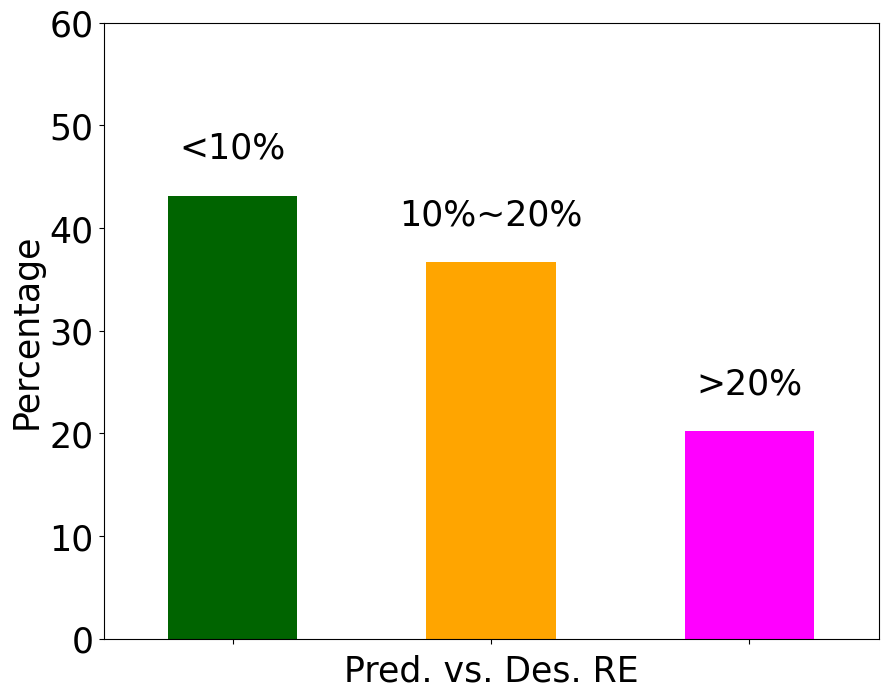

In [76]:
# plot the error bars <10%, <20%
re_less_10 = np.sum(gen_SMILES_sampled['Err_pred_des'].values <= 0.1)
print (
    'less than 10 % ', re_less_10, 
    'from total ', gen_SMILES_sampled.shape[0], 
    re_less_10/gen_SMILES_sampled.shape[0], "%")
re_less_20_big_10 = np.sum( (gen_SMILES_sampled['Err_pred_des'].values > 0.1) &  (gen_SMILES_sampled['Err_pred_des'].values <= 0.2) )
print ('less than 20 larger than 10% ', re_less_20_big_10, 'from total ', gen_SMILES_sampled.shape[0], re_less_20_big_10/gen_SMILES_sampled.shape[0], "%")
re_big_20 = np.sum(gen_SMILES_sampled['Err_pred_des'].values > 0.2)
print ('larger than 20 % ', re_big_20, 'from total ', gen_SMILES_sampled.shape[0], re_big_20/gen_SMILES_sampled.shape[0], "%")
print ('total: ', re_less_10 + re_less_20_big_10 + re_big_20)

plt.figure(figsize = (10, 8))
frequencies = [re_less_10/len(gen_SMILES_sampled)*100, re_less_20_big_10/len(gen_SMILES_sampled)*100, re_big_20/len(gen_SMILES_sampled)*100]
freq_series = pd.Series(frequencies)
ax = freq_series.plot(kind='bar', color = ['darkgreen', 'orange', 'magenta'])
rects = ax.patches
x_labels = [ ]
labels = ['<10%', '10%~20%', '>20%']

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 3, label,fontsize = 25,
            ha='center', va='bottom')
ax.set_xticklabels(x_labels)
plt.ylim(0,60)
plt.yticks(fontsize = 25)
plt.ylabel("Percentage", fontsize=25)
plt.xlabel("Pred. vs. Des. RE", fontsize=25)
plt.savefig('Err_pred_des_dist_3part.png', dpi=300)

In [79]:
gen_SMILES_sampled['AE'] = [abs(i-j) for i, j in zip (gen_SMILES_sampled['des_gap'], gen_SMILES_sampled['pred_gap'])]

In [80]:
np.mean (gen_SMILES_sampled['AE'])

1.0709036225490196

In [81]:
gen_SMILES_sampled.to_csv ('./../experiments/regular/keep/Initial_training_510dftSampled.csv', index=False)

<Axes: xlabel='pred_gap', ylabel='Percent'>

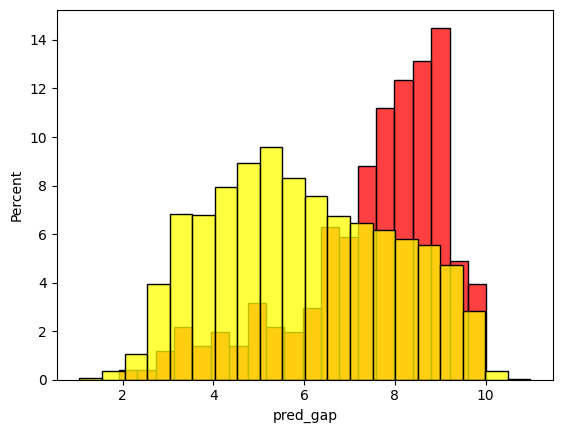

In [82]:
sns.histplot(gen_SMILES_sampled ['pred_gap'], color='red', stat='percent', bins=20)
sns.histplot(gap_pubqc, color='yellow', stat='percent', bins=20)

In [83]:
print (np.min(pred_gap))
print (np.max(pred_gap))

1.9205086
10.144481


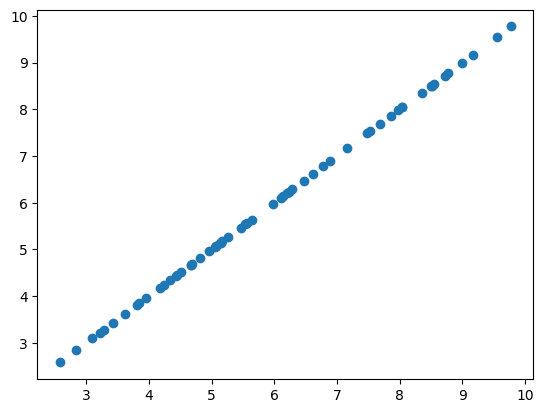

In [160]:
# sample 70 samples from PubChemQC
np.random.seed(22)
idx = np.random.choice(len(y_train0), 60, replace = False)
data_pubqc_sampled = data_pubqc.iloc[idx]
plt.scatter (data_pubqc_sampled['gap'], data_pubqc_sampled['gap'])

data_pubqc_sampled.to_csv ('./../experiments/regular/keep/PubChemqc60Sampled.csv', index=False)